In [28]:
import pandas as pd
import numpy as np
import sys

# Add the ptdraft folder path to the sys.path list
sys.path.append('../../_util/')
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import quantile_transform
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import OneHotEncoder  ##. better to use dummy from pandas
from sklearn.preprocessing import PowerTransformer
from scipy.stats import boxcox
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from scipy.stats import boxcox
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from _util import xY_spliter
from _util import categorical_numerical_spliter
pd.options.display.max_rows = 100



baseDf = pd.read_csv('../../data/Data_Marketing_Customer_Analysis_Round3.csv')

#split numerical and categorical data frames

In [29]:
# numerical = baseDf.select_dtypes(include=np.number)
# categorical = baseDf.select_dtypes(include=object)

numerical, categorical= categorical_numerical_spliter(baseDf)


check if there are highly correlated features and drop them if there are any.


In [30]:
cor_matrix = numerical.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))

to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
baseDf.drop(to_drop, axis=1, inplace=True)

In [31]:
categorical

,region,response,coverage,education,effective_to_date,employment_status,gender,location_code,marital_status,policy_type,policy,renew_offer_type,sales_channel,vehicle_class,vehicle_size
0,arizona,no,basic,college,2/18/11,employed,m,suburban,married,corporate auto,corporate l3,offer3,agent,four-door car,medsize
1,california,no,basic,college,1/18/11,unemployed,f,suburban,single,personal auto,personal l3,offer4,call center,four-door car,medsize
2,washington,no,basic,bachelor,2/10/11,employed,m,suburban,single,personal auto,personal l3,offer3,call center,suv,medsize
3,oregon,yes,extended,college,1/11/11,employed,m,suburban,single,corporate auto,corporate l3,offer2,branch,four-door car,medsize
4,oregon,no,premium,bachelor,1/17/11,medical leave,f,suburban,married,personal auto,personal l2,offer1,branch,four-door car,medsize
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10597,nevada,no,premium,bachelor,1/19/11,unemployed,f,suburban,married,personal auto,personal l1,offer3,web,luxury car,medsize
10598,oregon,no,basic,college,1/6/11,employed,f,urban,married,personal auto,personal l3,offer2,branch,four-door car,medsize
10599,arizona,no,extended,bachelor,2/6/11,employed,f,rural,married,corporate auto,corporate l3,offer1,web,luxury suv,medsize
10600,california,no,premium,college,2/13/11,employed,f,urban,divorced,personal auto,personal l1,offer1,branch,suv,medsize


One Hot/Label Encoding of the categorical variables in the categoricals data frame that you created in Activity 4. ( Hint: check Dropfirst option).

In [32]:
categorical = pd.get_dummies(categorical, drop_first=True)

# cdf = pd.concat([numerical, categorical], axis=1)


for the first iteration, we will focus on the numericals data (numericals data frame) as our data source.
(optional) remove the outliers from the numerical columns.

In [33]:
# numerical[(np.abs(stats.zscore(numerical)) < 3).all(axis=1)]

In [34]:
X, y = xY_spliter(numerical, 'total_claim_amount')

##Linear Regression

Train-test split.

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=123)
cat_train, cat_test, _, _ = train_test_split(categorical, y, test_size=.30, random_state=123)

Standardize the data (after the data split).

In [36]:
std_scaler = StandardScaler().fit(X_train)  # mean and std
X_train_scaled_source = std_scaler.transform(X_train)
# X_train.shape
X_test_scaled_source = std_scaler.transform(X_test)


In [37]:
cat_train.reset_index(drop=True, inplace=True)
cat_test.reset_index(drop=True, inplace=True)

X_train_scaled_df = pd.DataFrame(X_train_scaled_source)
X_test_scaled_df = pd.DataFrame(X_test_scaled_source)

X_train_scaled =  pd.concat([X_train_scaled_df, cat_train], axis=1,ignore_index=False)
X_test_scaled =  pd.concat([X_test_scaled_df, cat_test], axis=1,ignore_index=False)



In [38]:
X_train_scaled

,0,1,2,3,4,5,6,region_california,region_nevada,region_oregon,...,sales_channel_branch,sales_channel_call center,sales_channel_web,vehicle_class_luxury car,vehicle_class_luxury suv,vehicle_class_sports car,vehicle_class_suv,vehicle_class_two-door car,vehicle_size_medsize,vehicle_size_small
0,-0.441895,-1.675796,-0.820636,1.850886,-0.464635,-0.418969,0.421958,0,0,0,...,1,0,0,0,0,0,0,1,0,1
1,-0.751415,0.377699,-0.616090,1.062773,1.787596,-0.418969,-0.825427,0,0,1,...,0,1,0,0,0,0,0,1,1,0
2,-0.794902,-1.335910,-0.645311,-0.217910,-0.857882,-0.418969,-0.825427,1,0,0,...,0,0,1,0,0,0,0,0,1,0
3,1.084543,1.320808,0.085214,-1.006022,0.214609,-0.418969,-0.409632,0,0,1,...,1,0,0,0,0,0,0,0,1,0
4,-0.436933,0.101395,-0.908299,-0.414938,1.287100,-0.418969,0.006163,0,0,0,...,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7416,1.027338,-0.667368,-0.499206,-0.119396,-0.750633,-0.418969,-0.409632,0,0,1,...,1,0,0,0,0,0,0,0,1,0
7417,-0.386733,-0.928160,-0.586869,-0.907508,1.751846,-0.418969,2.500933,0,1,0,...,0,0,0,0,0,0,0,0,1,0
7418,-0.671007,0.872097,-0.265438,0.274661,-1.072380,-0.418969,-0.825427,0,0,1,...,0,0,0,0,0,0,0,0,1,0
7419,-0.740178,1.008229,-0.586869,-1.301565,0.250359,0.685531,-0.825427,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [39]:
model = LinearRegression()  # model
model.fit(X_train_scaled, y_train)  # model train

C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


LinearRegression()

In [40]:
model.coef_

array([-7.33349526e-01, -6.31872804e+00,  1.85243657e+02,  3.70209155e+00,
        1.59833143e-01, -2.02389584e+00,  1.55966536e+00,  8.25683507e+00,
        8.33215052e+00, -5.47804272e-01,  8.36910794e+00, -2.67517449e+01,
       -1.57297387e+01, -1.93401044e+01, -1.03080163e+01, -1.26779542e+01,
        1.12726929e+01, -1.38459387e+01,  1.50357809e+01, -1.32968737e-02,
        2.51263074e+00,  4.39509274e+01,  1.49382862e+01,  1.24938807e+01,
       -3.47466953e+00, -1.05504182e+01, -4.66111055e+00, -5.94809922e-01,
        5.59523876e+00,  2.34758073e+01,  8.39839327e+00,  1.27425235e+01,
        8.00975691e+00, -1.53412917e+01,  2.99919423e+01,  3.82932369e+01,
        2.02733498e+01,  1.99500450e+01,  4.04271183e+01,  2.23567989e+01,
       -1.15119103e+01,  1.21594448e+01,  1.81704360e+00,  2.07732320e+01,
        2.13822967e+01, -2.30454142e-01,  1.04567826e+00, -6.39541700e+00,
        3.16759538e+00,  2.19942365e+01,  9.73833465e-01,  1.02551667e+01,
        3.79942671e+01, -

In [41]:
model.intercept_

124.74460293434089

In [42]:
model.score(X_test_scaled, y_test)

C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


0.7561883751699814

Apply linear regression.

In [43]:
y_pred = model.predict(X_test_scaled)
y_pred_train = model.predict(X_train_scaled)

C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [44]:
y_test

9774    1072
8236     453
4825     421
8032    1389
34       499
        ... 
7469     643
5918     383
2772     238
8265     340
6325      47
Name: total_claim_amount, Length: 3181, dtype: int64

In [45]:
y_pred

array([936.74616624, 377.16423098, 377.59074861, ..., 290.13241509,
       385.57512361,  75.79650651])

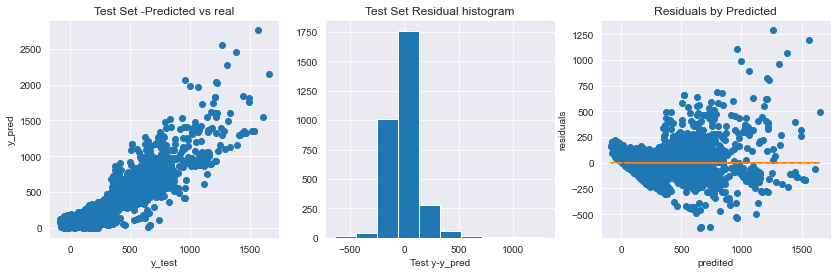

In [46]:
result = pd.DataFrame({"y_test": y_test, "y_pred": y_pred})

fig, ax = plt.subplots(1, 3, figsize=(14, 4))
ax[0].plot(y_pred, y_test, 'o')
ax[0].set_xlabel("y_test")
ax[0].set_ylabel("y_pred")
ax[0].set_title("Test Set -Predicted vs real")

# Get a histogram of the residuals ie: y - y_pred.  Homoscdasticity
# It resembles a normal distribution?
ax[1].hist(y_test - y_pred)
ax[1].set_xlabel("Test y-y_pred")
ax[1].set_title("Test Set Residual histogram")

ax[2].plot(y_pred, y_test - y_pred, "o")
ax[2].set_xlabel("predited")
ax[2].set_ylabel("residuals")
ax[2].set_title("Residuals by Predicted")
ax[2].plot(y_pred, np.zeros(len(y_pred)), linestyle='dashed')

In [47]:
print(mse(y_test, y_pred))
print(mae(y_test, y_pred))


20823.287734795704
99.15108890045438


In [48]:
mse(y_train, y_pred_train)

19160.21616668341

In [49]:
R2 = r2_score(y_test, y_pred)
R2

0.7561883751699814

In [50]:
R2_test = model.score(X_test_scaled, y_test)
R2_train = model.score(X_train_scaled, y_train)

C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [51]:
X_train_scaled.shape

(7421, 108)

In [52]:
features_importances = pd.DataFrame(data={
    'Attribute': X_train_scaled.columns,
    'Importance': abs(model.coef_)
})
features_importances = features_importances.sort_values(by='Importance', ascending=False)

In [53]:
features_importances

,Attribute,Importance
92,policy_special l1,1.366438e+15
94,policy_special l3,1.366438e+15
86,policy_type_special auto,1.366438e+15
93,policy_special l2,1.366438e+15
89,policy_personal l1,4.159181e+13
...,...,...
105,vehicle_class_two-door car,2.023011e-01
4,4,1.598331e-01
99,sales_channel_call center,6.832393e-02
19,effective_to_date_1/11/11,1.329687e-02


TypeError: 'value' must be an instance of str or bytes, not a int

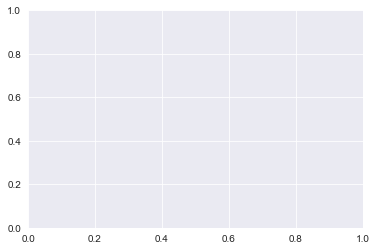

In [54]:
plt.bar(x=features_importances['Attribute'], height=features_importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
features_importances['Attribute']